<a href="https://colab.research.google.com/github/NiloufarYousefi/-Final-project/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Time Series Forecasting with RNN in PyTorch

In this tutorial, we will practice on a hands-on example of using Vanilla RNNs for time series forecasting. We will code in PyTorch to predict future values of a simple time series (e.g., predicting the next value in a sine wave sequence).

We start with importing libraries:

- numpy and torch for numerical operations and model training.

- matplotlib for plotting the time series data.

- sklearn.preprocessing.MinMaxScaler for normalizing the data between -1 and 1.

In [ ]:
# importing required packages

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Next, we will Generate and Normalize Time Series Data:

- Generate a sine wave to simulate time series data using np.sin().

- Normalize the data using MinMaxScaler for faster and stable training.

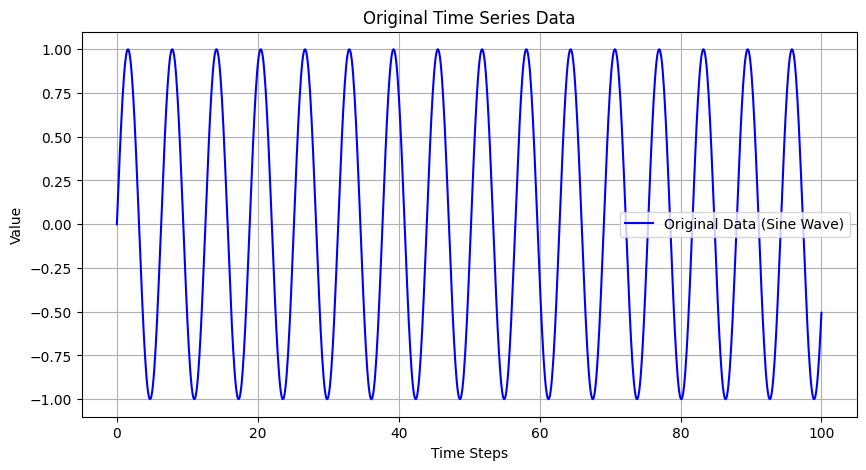

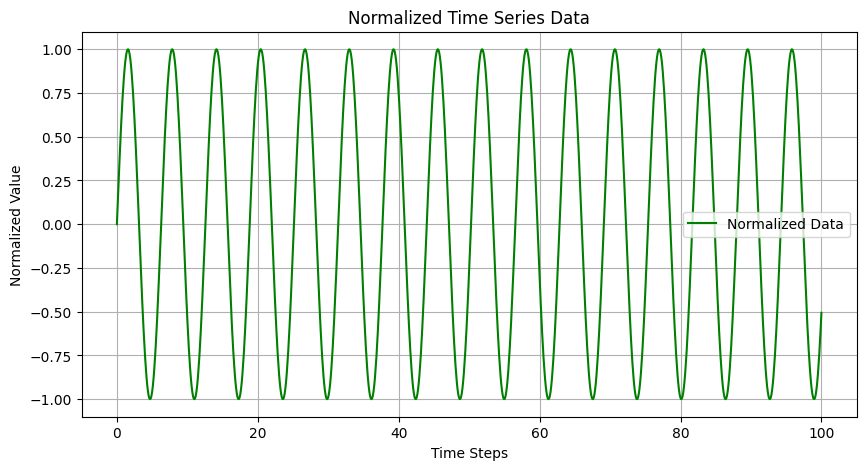

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Plot the original time series
plt.figure(figsize=(10, 5))
plt.plot(time_steps, data, label='Original Data (Sine Wave)', color='blue')
plt.title('Original Time Series Data')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# Plot the normalized time series
plt.figure(figsize=(10, 5))
plt.plot(time_steps, data_normalized, label='Normalized Data', color='green')
plt.title('Normalized Time Series Data')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.legend()
plt.show()

**Prepare Input-Output Sequences:**

- Define create_inout_sequences() to split the time series data into sequences.

- The input sequence length is seq_length, and the label is the value that follows this sequence.

- Each training pair is a sliding window over the time series data.

In [ ]:
# Prepare data for RNN input (sequence-to-sequence)
def create_inout_sequences(input_data, seq_length):
    """
    Prepare input-output pairs for RNN training.
    input_data: The normalized time series data.
    seq_length: The number of time steps in each input sequence.
    """
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 30
inout_seq = create_inout_sequences(data_normalized, seq_length)

**Convert Data into PyTorch Tensors:**

- Convert the input sequences and labels into PyTorch tensors for training.

- Add a dimension to the input sequence using unsqueeze(1) to match the expected input shape for the RNN.

In [ ]:
# Convert data into PyTorch tensors
train_sequences = [torch.FloatTensor(seq).unsqueeze(1) for seq, _ in inout_seq]
train_labels = [torch.FloatTensor([label]) for _, label in inout_seq]

**Define the RNN Model:**

- Use nn.RNN for the recurrent layer, specifying input size, hidden layer size, and setting batch_first=True for easier batch processing.

- A linear layer (nn.Linear) maps the hidden state to the output.

- Initialize the hidden state with zeros in the forward method.

In [ ]:
# Define the RNN Model
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        """
        Initialize the RNN model.
        input_size: Number of features in the input (1 for univariate time series).
        hidden_layer_size: Number of hidden units in the RNN.
        output_size: Number of features in the output.
        """
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = None

    def forward(self, input_seq):
        """
        Forward pass through the RNN.
        input_seq: The input sequence tensor.
        """
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)  # Initialize hidden state
        rnn_out, h_n = self.rnn(input_seq, h_0)
        # Use the output of the last time step for prediction
        prediction = self.linear(rnn_out[:, -1])
        return prediction

**Model, Loss Function, and Optimizer:**

- Instantiate the RNN model.

- Use nn.MSELoss() as the loss function because this is a regression problem.

- Use the Adam optimizer with a learning rate of 0.001 for efficient training.

In [ ]:
# Instantiate the model, define loss function and optimizer
model = RNN()
loss_function = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Training Loop:**

- Iterate through the training sequences for a defined number of epochs.
For each sequence, perform a forward pass, compute loss, backpropagate, and update weights.

- Print the loss every 10 epochs to monitor training progress.

In [ ]:
# Train the RNN model
epochs = 40 #100 for testing at home
for epoch in range(epochs):
    for seq, label in zip(train_sequences, train_labels):
        optimizer.zero_grad()
        y_pred = model(seq.unsqueeze(0))  # Add batch dimension
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {single_loss.item()}')

Epoch 0 Loss: 2.4657929316163063e-06
Epoch 10 Loss: 0.0011083331191912293
Epoch 20 Loss: 0.0025394049007445574
Epoch 30 Loss: 0.0002322598302271217


**Making Predictions:**

- Set the model to evaluation mode with model.eval().

- Use the last seq_length values of the time series to predict future values one step at a time.

- Append each prediction to test_inputs and use it as input for the next step.

In [ ]:
# Make predictions using the trained model
model.eval()
future_steps = 100  # Predict 100 future time steps
test_inputs = data_normalized[-seq_length:].tolist()  # Use the last seq_length values as input

# Predict future values step by step
for _ in range(future_steps):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(0).unsqueeze(2)
    with torch.no_grad():
        test_inputs.append(model(seq).item())


**Rescale and Plot Predictions:**

- Use the inverse transform of the MinMaxScaler to convert the normalized predictions back to the original scale.

- Plot both the original time series and the predicted values for the future steps.

**Result Visualization:**

- The plot displays the original time series data and the RNN's predicted continuation of the sine wave.

- This helps in visualizing the model’s ability to capture the trend in the data.

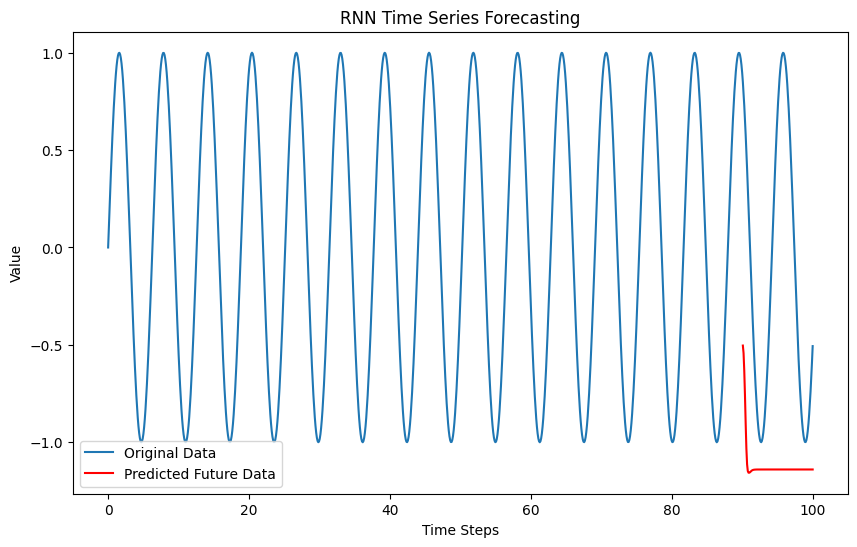

In [ ]:
# Rescale the predictions back to the original scale
predicted_values = scaler.inverse_transform(np.array(test_inputs[seq_length:]).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data, label='Original Data')
plt.plot(time_steps[-future_steps:], predicted_values, label='Predicted Future Data', color='red')
plt.title('RNN Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

The behavior ywe're observing, where the loss decreases initially but then starts to increase again after a few epochs, can be attributed to several potential issues that often occur when training RNNs.

Here are the most common reasons for such behavior:

1. **Overfitting:**

The initial drop in loss suggests that the model is learning the training data well. However, as training continues, the model may start to overfit the training data, which means it memorizes the training sequences rather than learning general patterns.
This can cause the loss to increase again, as the model becomes less capable of making general predictions for unseen or new sequences.
Solution: To mitigate overfitting, you can:
Use Dropout layers between RNN layers to prevent the model from over-relying on specific neurons.
Reduce the number of hidden units or complexity of the model.
Apply early stopping to stop training when the loss on a validation set stops improving.

2. **Learning Rate Issues:**

A learning rate that is too high can cause the loss to oscillate or diverge after initially decreasing. This means the model takes too large steps during optimization, overshooting the optimal weights after some epochs.
The sudden jumps in loss values at later epochs could be a sign of the optimizer overshooting.
Solution: Try reducing the learning rate. For example, if the learning rate is 0.001, try 0.0001.
You can also use a learning rate scheduler that reduces the learning rate as training progresses.

3. **Exploding Gradients:**

Exploding gradients are common in RNNs and occur when gradients grow exponentially during backpropagation through time (BPTT). This can cause instability in training and lead to sudden spikes in the loss, as the model struggles to update its weights correctly.
In this case, the increasing loss after epoch 10 could suggest that the gradients have grown too large, resulting in poor updates.

Epoch 0 Loss: 0.000375
Epoch 10 Loss: 0.000290
Epoch 20 Loss: 0.000228
Epoch 30 Loss: 0.000124


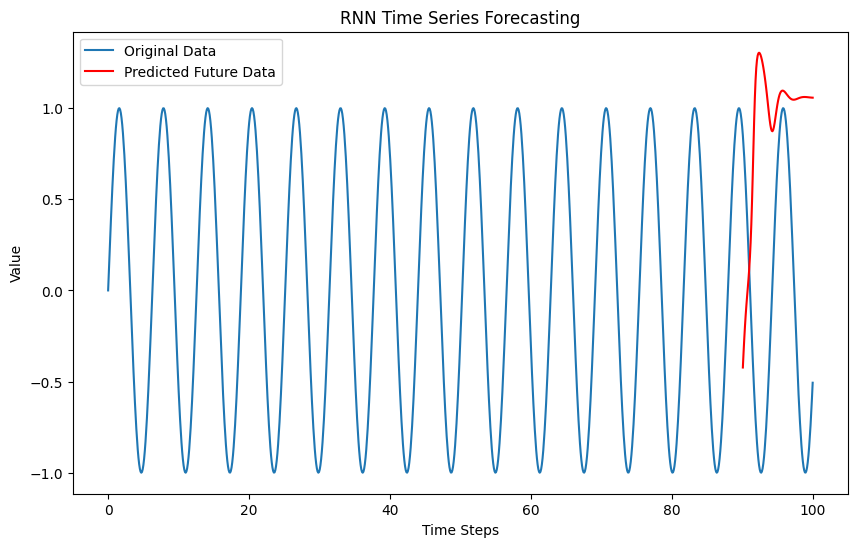

In [ ]:
# Define the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #try different optimizer: https://pytorch.org/docs/stable/optim.html

# Train the RNN model with gradient clipping
epochs = 40 #at home run this with 100 epochs
for epoch in range(epochs):
    epoch_loss = 0
    for seq, label in zip(train_sequences, train_labels):
        optimizer.zero_grad()
        y_pred = model(seq.unsqueeze(0))  # Add batch dimension
        single_loss = loss_function(y_pred, label)
        single_loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_loss += single_loss.item()

    epoch_loss /= len(train_sequences)
    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {epoch_loss:.6f}')

# Make predictions using the trained model
model.eval()
future_steps = 100  # Predict 100 future time steps
test_inputs = data_normalized[-seq_length:].tolist()  # Use the last seq_length values as input

# Predict future values step by step
for _ in range(future_steps):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(0).unsqueeze(2)
    with torch.no_grad():
        test_inputs.append(model(seq).item())


# Rescale the predictions back to the original scale
predicted_values = scaler.inverse_transform(np.array(test_inputs[seq_length:]).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data, label='Original Data')
plt.plot(time_steps[-future_steps:], predicted_values, label='Predicted Future Data', color='red')
plt.title('RNN Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

**Key Points to Monitor:**

**Early Stopping:** Stop training if the loss does not improve over a set number of epochs.

**Validation Loss:** Use a validation set to check if the model is overfitting (i.e., training loss decreasing but validation loss increasing).

**Gradient Clipping and Learning Rate:** Often, these adjustments are sufficient to stabilize training in RNNs.

RNNs can learn patterns in sequences and predict future values, but may struggle with long-term dependencies.

Using normalized data and proper scaling is crucial for stable training of RNNs.

### 2. Time Series Forecasting with LSTM in PyTorch

1. Import Libraries:

- Uses *numpy* and torch for numerical operations and deep learning.

- *matplotlib* is for visualizing the time series data.

- *sklearn.preprocessing.MinMaxScaler* for normalizing the data to a range of -1 to 1.


In [ ]:
# lstm_time_series_forecasting.py

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


2. Generate and Normalize Time Series Data:

- Creates a simple sine wave as time series data.

- Normalizes the sine wave using MinMaxScaler to ensure all values are between -1 and 1 for stable training.

In [ ]:

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)


3. Prepare Input-Output Sequences:

The *create_inout_sequences()* function generates input sequences and their corresponding labels.

The sequence length (*seq_length*) determines how many time steps are considered for predicting the next value.

In [ ]:
# Prepare data for LSTM input (sequence-to-sequence)
def create_inout_sequences(input_data, seq_length):
    """
    Prepare input-output pairs for LSTM training.
    input_data: The normalized time series data.
    seq_length: The number of time steps in each input sequence.
    """
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

4. Convert Data into PyTorch Tensors:

Each sequence and label pair is converted into a PyTorch tensor.
The input sequences are reshaped with unsqueeze(1) to match the LSTM's expected input shape.

In [ ]:
seq_length = 30
inout_seq = create_inout_sequences(data_normalized, seq_length)

# Convert data into PyTorch tensors
train_sequences = [torch.FloatTensor(seq).unsqueeze(1) for seq, _ in inout_seq]
train_labels = [torch.FloatTensor([label]) for _, label in inout_seq]

5. Define the LSTM Model:

- The LSTM model is defined using *nn.LSTM* for the recurrent layer.

- The *hidden* state and cell state are initialized as zero tensors.

- *nn.Linear* maps the output of the LSTM to the desired output size (1 for univariate prediction).

In [ ]:
# Define the LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        """
        Initialize the LSTM model.
        input_size: Number of features in the input (1 for univariate time series).
        hidden_layer_size: Number of hidden units in the LSTM.
        output_size: Number of features in the output.
        """
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, hidden_layer_size),
                            torch.zeros(1, 1, hidden_layer_size))  # Initialize hidden and cell states

    def forward(self, input_seq):
        """
        Forward pass through the LSTM.
        input_seq: The input sequence tensor.
        """
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        prediction = self.linear(lstm_out[:, -1])
        return prediction

6. Model, Loss Function, and Optimizer:

- nn.MSELoss() is used for regression, as it measures the mean squared error between predicted and actual values.

- torch.optim.Adam() is chosen for optimization due to its efficient handling of gradients and adaptive learning rates.

In [ ]:
# Instantiate the model, define loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

7. Training Loop:

- Iterates over the input sequences for a defined number of epochs.

- Resets the hidden state and cell state at the beginning of each sequence to ensure independence between batches.

- Performs a forward pass, computes the loss, backpropagates, and updates weights.

- Logs the loss every 10 epochs for monitoring training progress.

In [ ]:
# Train the LSTM model
epochs = 40 # test at home with 100 epochs
for epoch in range(epochs):
    for seq, label in zip(train_sequences, train_labels):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))  # Reset hidden and cell state

        y_pred = model(seq.unsqueeze(0))  # Add batch dimension
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {single_loss.item()}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.0009599371114745736
Epoch 10 Loss: 0.00030452138162218034
Epoch 20 Loss: 4.774168701260351e-06
Epoch 30 Loss: 0.0005473623750731349


8. Making Predictions:

- The model is set to evaluation mode using model.eval().

- Uses the last seq_length values of the time series to predict future values step-by-step.

- Resets the hidden and cell state before each new prediction to prevent state leakage.

In [ ]:
# Make predictions using the trained model
model.eval()
future_steps = 100  # Predict 100 future time steps
test_inputs = data_normalized[-seq_length:].tolist()  # Use the last seq_length values as input

# Predict future values step by step
for _ in range(future_steps):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(0).unsqueeze(2)
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))  # Reset hidden and cell state
        test_inputs.append(model(seq).item())

9. Rescale and Plot Predictions:

- The MinMaxScaler's inverse transform converts the normalized predictions back to the original scale.

- matplotlib is used to plot both the original time series data and the predicted values for the next 100 steps.

10. Result Visualization:

The plot will show the sine wave data along with the continuation predicted by the LSTM.

This visualization helps in assessing how well the LSTM captures the periodic pattern of the sine wave.

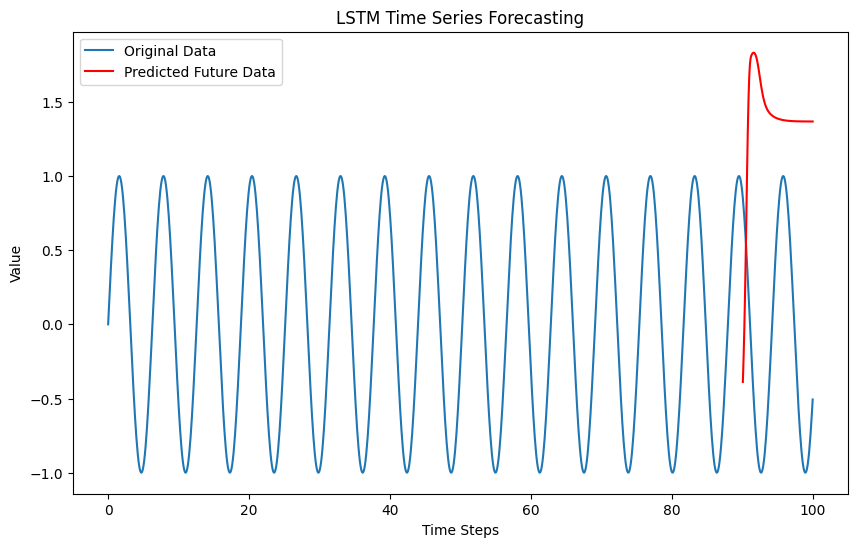

In [ ]:
# Rescale the predictions back to the original scale
predicted_values = scaler.inverse_transform(np.array(test_inputs[seq_length:]).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data, label='Original Data')
plt.plot(time_steps[-future_steps:], predicted_values, label='Predicted Future Data', color='red')
plt.title('LSTM Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

**Key Takeaways:**

- LSTM models are more capable than simple RNNs when dealing with longer
sequences, thanks to their use of memory cells and gating mechanisms.

- They excel at capturing patterns in time series data and are particularly effective when sequences contain long-term dependencies.

- The code can be adapted for other time series datasets, such as stock prices, temperature data, or any univariate sequence.

###  3. Time Series Forecasting with GRU in PyTorch

This code example is similar to the LSTM example but uses a GRU for time series forecasting.

1. Model Definition:

- The GRU class defines a GRU-based model using nn.GRU.

- Only two gates are used (update and reset), making it simpler than the LSTM.

- The hidden state is initialized with zeros.

2. Training Loop:

- Similar to the LSTM example, it iterates over the training sequences and resets the hidden state for each new sequence.

- Uses nn.MSELoss() for regression and Adam optimizer for efficient training.


3. Prediction Loop:

- Uses the last seq_length time steps to generate predictions for future values, appending each prediction to the input sequence.

- This allows the GRU to predict the next value in a sequence, similar to rolling out predictions step-by-step.


4. Visualization:

- The sine wave data and predicted continuation are plotted to show how well the GRU captures the pattern of the time series.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.009774813428521156
Epoch 10 Loss: 0.00044537914800457656
Epoch 20 Loss: 6.463123281719163e-05
Epoch 30 Loss: 0.0037138466723263264


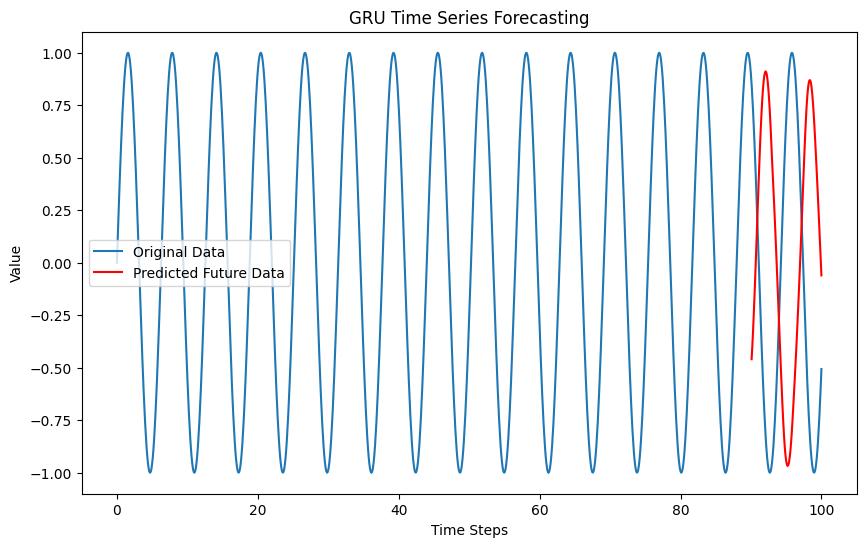

In [ ]:
# File: gru_time_series_forecasting.py

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Prepare data for GRU input (sequence-to-sequence)
def create_inout_sequences(input_data, seq_length):
    """
    Prepare input-output pairs for GRU training.
    input_data: The normalized time series data.
    seq_length: The number of time steps in each input sequence.
    """
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 30
inout_seq = create_inout_sequences(data_normalized, seq_length)

# Convert data into PyTorch tensors
train_sequences = [torch.FloatTensor(seq).unsqueeze(1) for seq, _ in inout_seq]
train_labels = [torch.FloatTensor([label]) for _, label in inout_seq]

# Define the GRU Model
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        """
        Initialize the GRU model.
        input_size: Number of features in the input (1 for univariate time series).
        hidden_layer_size: Number of hidden units in the GRU.
        output_size: Number of features in the output.
        """
        super(GRU, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_state = None

    def forward(self, input_seq):
        """
        Forward pass through the GRU.
        input_seq: The input sequence tensor.
        """
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)  # Initialize hidden state
        gru_out, h_n = self.gru(input_seq, h_0)
        prediction = self.linear(gru_out[:, -1])
        return prediction

# Instantiate the model, define loss function and optimizer
model = GRU()
loss_function = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the GRU model
epochs = 40 # use 100 epochs at home
for epoch in range(epochs):
    for seq, label in zip(train_sequences, train_labels):
        optimizer.zero_grad()
        y_pred = model(seq.unsqueeze(0))  # Add batch dimension
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {single_loss.item()}')

# Make predictions using the trained model
model.eval()
future_steps = 100  # Predict 100 future time steps
test_inputs = data_normalized[-seq_length:].tolist()  # Use the last seq_length values as input

# Predict future values step by step
for _ in range(future_steps):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(0).unsqueeze(2)
    with torch.no_grad():
        test_inputs.append(model(seq).item())

# Rescale the predictions back to the original scale
predicted_values = scaler.inverse_transform(np.array(test_inputs[seq_length:]).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data, label='Original Data')
plt.plot(time_steps[-future_steps:], predicted_values, label='Predicted Future Data', color='red')
plt.title('GRU Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()


**Key Takeaways:**

***GRU vs. LSTM:***


- GRUs are simpler and can be more computationally efficient for certain tasks.

- LSTMs may perform better when the dataset has longer sequences with complex dependencies.

- For this example, you can compare the loss values and prediction accuracy of the LSTM and GRU models to see which is better suited for your dataset.

### 4. Performance Comparison Between LSTM and GRU

To compare the performance between an LSTM and a GRU for time series forecasting, we can evaluate the models on two main aspects:

1. Training Time: Measure the time taken by each model to train for a fixed number of epochs.

2. Loss Values: Track and compare the loss values to understand how quickly and effectively each model learns the time series patterns.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Prepare data for RNN input (sequence-to-sequence)
def create_inout_sequences(input_data, seq_length):
    """
    Prepare input-output pairs for RNN training.
    input_data: The normalized time series data.
    seq_length: The number of time steps in each input sequence.
    """
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 30
inout_seq = create_inout_sequences(data_normalized, seq_length)

# Convert data into PyTorch tensors
train_sequences = [torch.FloatTensor(seq).unsqueeze(1) for seq, _ in inout_seq]
train_labels = [torch.FloatTensor([label]) for _, label in inout_seq]

**1. Unified Model Definition (RNNBase):**

A generic class RNNBase is defined to handle both LSTM and GRU models using the rnn_type parameter.

Based on the rnn_type, the model initializes either an nn.LSTM or an nn.GRU layer.

The forward method handles both LSTM (which uses hidden and cell states) and GRU (which uses only a hidden state).

In [ ]:
# Define a base RNN model class that can be used for LSTM and GRU
class RNNBase(nn.Module):
    def __init__(self, rnn_type='LSTM', input_size=1, hidden_layer_size=50, output_size=1):
        """
        Initialize the RNN model (LSTM or GRU).
        rnn_type: 'LSTM' or 'GRU'
        """
        super(RNNBase, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
        if self.rnn_type == 'LSTM':
            c_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
            rnn_out, _ = self.rnn(input_seq, (h_0, c_0))
        else:
            rnn_out, _ = self.rnn(input_seq, h_0)

        prediction = self.linear(rnn_out[:, -1])
        return prediction

**2. Training Function (train_model):**

A function train_model handles the training process for both models.

It tracks the mean squared error (MSE) loss for each epoch and records the training time.

The loss values for each epoch are stored in a list for later comparison.

In [ ]:
# Function to train the model and measure training time and loss
def train_model(model, train_sequences, train_labels, epochs=40, learning_rate=0.001): # use epochs=100 when testing at home
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0
        for seq, label in zip(train_sequences, train_labels):
            optimizer.zero_grad()
            y_pred = model(seq.unsqueeze(0))
            loss = loss_function(y_pred, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_sequences))
        if epoch % 10 == 0:
            print(f'{model.rnn_type} Epoch {epoch} Loss: {epoch_loss / len(train_sequences):.6f}')

    training_time = time.time() - start_time
    return losses, training_time

**3. Training and Evaluation:**

The LSTM and GRU models are instantiated and trained separately.

Training time for each model is recorded.

Loss values for each epoch are plotted to visualize the training progress.


**4. Plotting the Results:**

A line plot is generated to compare the loss values of LSTM and GRU over the training epochs.

This helps to visualize which model converges faster and achieves a lower loss.


**5. Output:**

The output will display the loss at every 10th epoch for each model.

The total training time is printed for each model.

The plot will show how the loss decreases for LSTM and GRU, indicating their learning behavior.


Training LSTM Model...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LSTM Epoch 0 Loss: 0.075514
LSTM Epoch 10 Loss: 0.003060
LSTM Epoch 20 Loss: 0.001234
LSTM Epoch 30 Loss: 0.000749

Training GRU Model...
GRU Epoch 0 Loss: 0.039249
GRU Epoch 10 Loss: 0.027047
GRU Epoch 20 Loss: 0.003543
GRU Epoch 30 Loss: 0.001922

LSTM Training Time: 88.28 seconds
GRU Training Time: 400.63 seconds


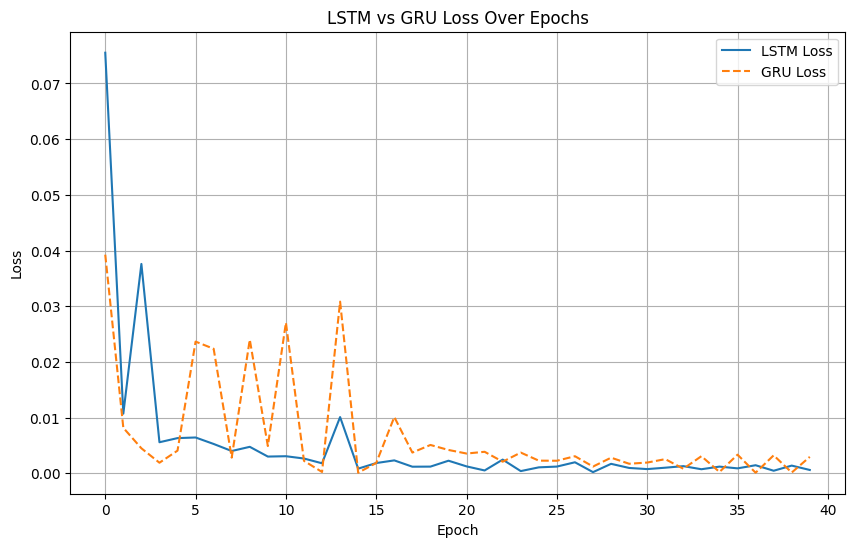

In [ ]:
# Instantiate the models
lstm_model = RNNBase(rnn_type='LSTM')
gru_model = RNNBase(rnn_type='GRU')

# Train the LSTM model
print("\nTraining LSTM Model...")
lstm_losses, lstm_time = train_model(lstm_model, train_sequences, train_labels)

# Train the GRU model
print("\nTraining GRU Model...")
gru_losses, gru_time = train_model(gru_model, train_sequences, train_labels)

# Print the training times
print(f"\nLSTM Training Time: {lstm_time:.2f} seconds")
print(f"GRU Training Time: {gru_time:.2f} seconds")

# Plot the loss comparison
plt.figure(figsize=(10, 6))
plt.plot(lstm_losses, label='LSTM Loss')
plt.plot(gru_losses, label='GRU Loss', linestyle='--')
plt.title('LSTM vs GRU Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of the Results:**

**- Training Time:** Compare lstm_time and gru_time to see which model is faster to train.
Typically, GRU models train faster due to fewer parameters.

**- Loss Convergence:** Compare the loss curves to see which model converges more quickly and reaches a lower loss. This helps determine which model learns the time series patterns more effectively.

**- Model Choice:** Based on the results:
Use **LSTM** if it provides significantly lower loss and better predictions, especially for long sequences.

Use **GRU** if it trains much faster with a similar level of accuracy, making it more suitable for real-time applications or shorter sequences.

### 5.  Compare Prediction Accuracy of LSTM and GRU

To  extend the comparison between LSTM and GRU models and evaluate their prediction accuracy on a test set, we can follow these steps:

**1. Split the Data into Training and Testing Sets:** This allows us to train the models on one part of the time series data and evaluate them on unseen data.

**2. Train the LSTM and GRU Models:** Use the same training procedure as before, but now evaluate the models' performance on the test set.

**3. Compute Mean Squared Error (MSE) on the Test Set:** Use the MSE metric to compare the prediction accuracy of both models.

**4. Compare Prediction Accuracy:** Print and visualize the prediction errors of both models to understand which performs better.

**Step 1. Data Preparation:**

**Training and Test Split:** 80% of the data is used for training, and 20% for testing. We include the last 30 points from the training set to serve as input sequences for predicting the test data.

**Input-Output Sequences:** The *create_inout_sequences()* function is used to prepare sequences of *length seq_length* for training and testing.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Split the data into training and test sets
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size - 30:]  # Include last 30 points for input to predict test set

# Prepare input-output sequences for training
def create_inout_sequences(input_data, seq_length):
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 30
train_sequences = create_inout_sequences(train_data, seq_length)
test_sequences = create_inout_sequences(test_data, seq_length)

# Convert data into PyTorch tensors for training
train_sequences = [(torch.FloatTensor(seq).unsqueeze(1), torch.FloatTensor([label])) for seq, label in train_sequences]
test_sequences = [(torch.FloatTensor(seq).unsqueeze(1), torch.FloatTensor([label])) for seq, label in test_sequences]


**Step 2. Model Definition:**

**RNNBase** is used to define both the LSTM and GRU models, as in the previous example.

We initialize and train each model separately.

In [ ]:
# Define a base RNN model class that can be used for LSTM and GRU
class RNNBase(nn.Module):
    def __init__(self, rnn_type='LSTM', input_size=1, hidden_layer_size=50, output_size=1):
        super(RNNBase, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
        if self.rnn_type == 'LSTM':
            c_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
            rnn_out, _ = self.rnn(input_seq, (h_0, c_0))
        else:
            rnn_out, _ = self.rnn(input_seq, h_0)

        prediction = self.linear(rnn_out[:, -1])
        return prediction

**Step 3. Training Function:**

`train_model()` trains the model for a specified number of epochs and returns the trained model and a list of training losses.

Training progress is printed every 10 epochs.

**Step 4. Model Evaluation:**

*evaluate_model()* generates predictions for each sequence in the test set using the trained model.

Stores predictions and corresponding actual values for later comparison.

In [ ]:
# Function to train the model and return the model
def train_model(model, train_sequences, epochs=40, learning_rate=0.001): #at home run this with epochs=100
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, label in train_sequences:
            optimizer.zero_grad()
            y_pred = model(seq.unsqueeze(0))
            loss = loss_function(y_pred, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_sequences)
        losses.append(epoch_loss)
        if epoch % 10 == 0:
            print(f'{model.rnn_type} Epoch {epoch} Loss: {epoch_loss:.6f}')

    return model, losses

# Instantiate and train the LSTM and GRU models
lstm_model = RNNBase(rnn_type='LSTM')
gru_model = RNNBase(rnn_type='GRU')

print("\nTraining LSTM Model...")
lstm_model, lstm_losses = train_model(lstm_model, train_sequences)

print("\nTraining GRU Model...")
gru_model, gru_losses = train_model(gru_model, train_sequences)

# Evaluate the models on the test set
def evaluate_model(model, test_sequences):
    predictions = []
    actuals = []
    model.eval()
    with torch.no_grad():
        for seq, label in test_sequences:
            y_pred = model(seq.unsqueeze(0))
            predictions.append(y_pred.item())
            actuals.append(label.item())

    return predictions, actuals

# Get predictions and actual values for both models
lstm_predictions, test_labels = evaluate_model(lstm_model, test_sequences)
gru_predictions, _ = evaluate_model(gru_model, test_sequences)


Training LSTM Model...
LSTM Epoch 0 Loss: 0.080059
LSTM Epoch 10 Loss: 0.001876
LSTM Epoch 20 Loss: 0.001845
LSTM Epoch 30 Loss: 0.000815

Training GRU Model...
GRU Epoch 0 Loss: 0.056134
GRU Epoch 10 Loss: 0.001452
GRU Epoch 20 Loss: 0.009551
GRU Epoch 30 Loss: 0.001626


**Step 5. Mean Squared Error Calculation:**

Uses mean_squared_error() from sklearn.metrics to compute the test MSE for each model.

This helps quantify the accuracy of each model on the unseen test set.

**Step 6. Visualization:**

- **Training Loss Comparison:** Plots the training loss over epochs for both LSTM and GRU to compare their learning curves.

- **Prediction Accuracy:** Plots the actual test values alongside the predictions from both models to visualize how well each model captures the time series pattern.


LSTM Test MSE: 0.002643
GRU Test MSE: 0.001384


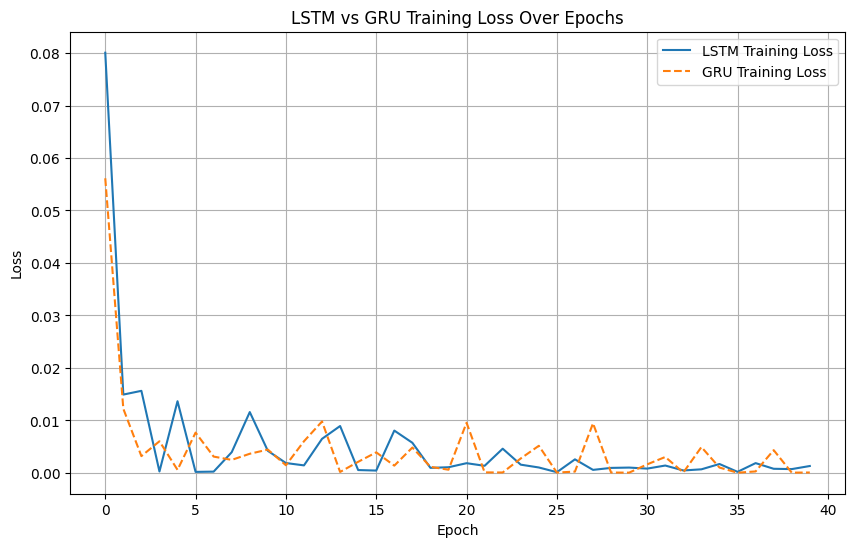

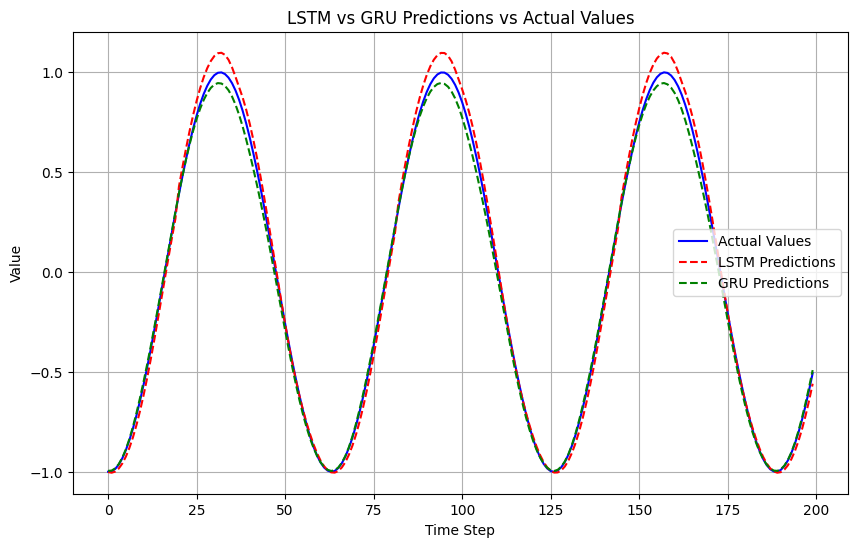

In [ ]:
# Calculate Mean Squared Error (MSE) for LSTM and GRU
lstm_mse = mean_squared_error(test_labels, lstm_predictions)
gru_mse = mean_squared_error(test_labels, gru_predictions)

print(f"\nLSTM Test MSE: {lstm_mse:.6f}")
print(f"GRU Test MSE: {gru_mse:.6f}")

# Plot the loss comparison
plt.figure(figsize=(10, 6))
plt.plot(lstm_losses, label='LSTM Training Loss')
plt.plot(gru_losses, label='GRU Training Loss', linestyle='--')
plt.title('LSTM vs GRU Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the predictions of both models against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual Values', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red', linestyle='--')
plt.plot(gru_predictions, label='GRU Predictions', color='green', linestyle='--')
plt.title('LSTM vs GRU Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of the Results:**

- **MSE Values:** The MSE values for LSTM and GRU on the test set indicate how well each model is able to generalize to unseen data.

- **Training Loss:** Compare how quickly the training loss decreases for each model and whether it stabilizes over time.

- **Prediction Plot:** Visually inspect how close the LSTM and GRU predictions are to the actual test values.

### 6. Cross-Validation with Different Hidden Layer Sizes

To improve the performance of the LSTM and GRU models, we can perform the following:

**- Change Hidden Layer Sizes:** Test different hidden layer sizes to observe their impact on model performance.

**- Cross-Validation:** Implement k-fold cross-validation to evaluate the models more robustly. Cross-validation helps ensure that the performance is consistent across different subsets of the data, rather than relying on a single training-test split.

We will use 3-fold cross-validation for simplicity.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import time

**1. Data Preparation:**

The time series data is generated, normalized, and split into sequences as before.

Using KFold from *sklearn.model_selection* for k-fold cross-validation ensures that each data point gets a chance to be in the test set.

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Prepare input-output sequences for training
def create_inout_sequences(input_data, seq_length):
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 30
data_sequences = create_inout_sequences(data_normalized, seq_length)

# Define a base RNN model class that can be used for LSTM and GRU
class RNNBase(nn.Module):
    def __init__(self, rnn_type='LSTM', input_size=1, hidden_layer_size=50, output_size=1):
        super(RNNBase, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
        if self.rnn_type == 'LSTM':
            c_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
            rnn_out, _ = self.rnn(input_seq, (h_0, c_0))
        else:
            rnn_out, _ = self.rnn(input_seq, h_0)

        prediction = self.linear(rnn_out[:, -1])
        return prediction

**2. Cross-Validation Function:**

cross_validate_model() performs k-fold cross-validation for the specified model type (LSTM or GRU) and hidden layer size.

For each fold:
- Train on a subset of the data and evaluate on the hold-out test subset.

- Store the Mean Squared Error (MSE) for each fold.

- Calculate and print the average MSE across all folds to get a robust estimate of the model's performance.

In [ ]:
# Function to train the model and return the mean MSE for k-fold cross-validation
def cross_validate_model(model_class, rnn_type, hidden_layer_size, data_sequences, k_folds=3, epochs=40, learning_rate=0.001):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_mse = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(data_sequences)):
        print(f'\n{rnn_type} Fold {fold + 1}/{k_folds} with Hidden Layer Size: {hidden_layer_size}')

        # Prepare train and test sequences for this fold
        train_sequences = [data_sequences[i] for i in train_idx]
        test_sequences = [data_sequences[i] for i in test_idx]

        # Convert sequences into PyTorch tensors
        train_sequences = [(torch.FloatTensor(seq).unsqueeze(1), torch.FloatTensor([label])) for seq, label in train_sequences]
        test_sequences = [(torch.FloatTensor(seq).unsqueeze(1), torch.FloatTensor([label])) for seq, label in test_sequences]

        # Instantiate the model
        model = model_class(rnn_type=rnn_type, hidden_layer_size=hidden_layer_size)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for seq, label in train_sequences:
                optimizer.zero_grad()
                y_pred = model(seq.unsqueeze(0))
                loss = loss_function(y_pred, label)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            if epoch % 10 == 0:
                print(f'Epoch {epoch} Loss: {epoch_loss / len(train_sequences):.6f}')

        # Evaluate on the test set
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for seq, label in test_sequences:
                y_pred = model(seq.unsqueeze(0))
                predictions.append(y_pred.item())
                actuals.append(label.item())

        # Calculate MSE for this fold and store it
        fold_mse.append(mean_squared_error(actuals, predictions))
        print(f'{rnn_type} Fold {fold + 1} MSE: {fold_mse[-1]:.6f}')

    # Return the average MSE across all folds
    avg_mse = np.mean(fold_mse)
    print(f'{rnn_type} with Hidden Layer Size {hidden_layer_size} Average MSE: {avg_mse:.6f}')
    return avg_mse

**3. Hyperparameter Tuning:**

We test hidden layer sizes of 20, 50, and 100 for both LSTM and GRU models.

For each size, run cross-validation and store the results.

In [ ]:
# Hyperparameter configurations to test
hidden_layer_sizes = [20, 50, 100]  # Different hidden layer sizes to test
k_folds = 3  # Number of folds for cross-validation
epochs = 50  # Training epochs for each fold

# Store results for comparison
results = {'LSTM': {}, 'GRU': {}}

# Run cross-validation for LSTM with different hidden layer sizes
for size in hidden_layer_sizes:
    results['LSTM'][size] = cross_validate_model(RNNBase, 'LSTM', size, data_sequences, k_folds=k_folds, epochs=epochs)

# Run cross-validation for GRU with different hidden layer sizes
for size in hidden_layer_sizes:
    results['GRU'][size] = cross_validate_model(RNNBase, 'GRU', size, data_sequences, k_folds=k_folds, epochs=epochs)



LSTM Fold 1/3 with Hidden Layer Size: 20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.115436
Epoch 10 Loss: 0.009232
Epoch 20 Loss: 0.002239
Epoch 30 Loss: 0.000021
Epoch 40 Loss: 0.000404
LSTM Fold 1 MSE: 0.000017

LSTM Fold 2/3 with Hidden Layer Size: 20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.156928
Epoch 10 Loss: 0.001304
Epoch 20 Loss: 0.000649
Epoch 30 Loss: 0.000826
Epoch 40 Loss: 0.000143
LSTM Fold 2 MSE: 0.000188

LSTM Fold 3/3 with Hidden Layer Size: 20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.101149
Epoch 10 Loss: 0.000469
Epoch 20 Loss: 0.000530
Epoch 30 Loss: 0.000025
Epoch 40 Loss: 0.000186
LSTM Fold 3 MSE: 0.000185
LSTM with Hidden Layer Size 20 Average MSE: 0.000130

LSTM Fold 1/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.090924
Epoch 10 Loss: 0.000497
Epoch 20 Loss: 0.001398
Epoch 30 Loss: 0.000773
Epoch 40 Loss: 0.000766
LSTM Fold 1 MSE: 0.000102

LSTM Fold 2/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.077421
Epoch 10 Loss: 0.000704
Epoch 20 Loss: 0.000345
Epoch 30 Loss: 0.000033
Epoch 40 Loss: 0.000639
LSTM Fold 2 MSE: 0.000472

LSTM Fold 3/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.080854
Epoch 10 Loss: 0.001670
Epoch 20 Loss: 0.000209
Epoch 30 Loss: 0.000672
Epoch 40 Loss: 0.000897
LSTM Fold 3 MSE: 0.000004
LSTM with Hidden Layer Size 50 Average MSE: 0.000193

LSTM Fold 1/3 with Hidden Layer Size: 100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.086412
Epoch 10 Loss: 0.000894
Epoch 20 Loss: 0.000825
Epoch 30 Loss: 0.000508
Epoch 40 Loss: 0.000280
LSTM Fold 1 MSE: 0.001655

LSTM Fold 2/3 with Hidden Layer Size: 100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.064427
Epoch 10 Loss: 0.001274
Epoch 20 Loss: 0.001048
Epoch 30 Loss: 0.000470
Epoch 40 Loss: 0.000432
LSTM Fold 2 MSE: 0.000161

LSTM Fold 3/3 with Hidden Layer Size: 100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.078208
Epoch 10 Loss: 0.000081
Epoch 20 Loss: 0.000199
Epoch 30 Loss: 0.000929
Epoch 40 Loss: 0.000493
LSTM Fold 3 MSE: 0.000158
LSTM with Hidden Layer Size 100 Average MSE: 0.000658

GRU Fold 1/3 with Hidden Layer Size: 20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.083167
Epoch 10 Loss: 0.003903
Epoch 20 Loss: 0.000200
Epoch 30 Loss: 0.000649
Epoch 40 Loss: 0.000389
GRU Fold 1 MSE: 0.000700

GRU Fold 2/3 with Hidden Layer Size: 20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.084419
Epoch 10 Loss: 0.001496
Epoch 20 Loss: 0.000468
Epoch 30 Loss: 0.000400
Epoch 40 Loss: 0.001055
GRU Fold 2 MSE: 0.000019

GRU Fold 3/3 with Hidden Layer Size: 20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.101849
Epoch 10 Loss: 0.000030
Epoch 20 Loss: 0.001238
Epoch 30 Loss: 0.001069
Epoch 40 Loss: 0.001374
GRU Fold 3 MSE: 0.000038
GRU with Hidden Layer Size 20 Average MSE: 0.000253

GRU Fold 1/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.060297
Epoch 10 Loss: 0.006305
Epoch 20 Loss: 0.000086
Epoch 30 Loss: 0.000017
Epoch 40 Loss: 0.000016
GRU Fold 1 MSE: 0.000063

GRU Fold 2/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.049551
Epoch 10 Loss: 0.001131
Epoch 20 Loss: 0.000154
Epoch 30 Loss: 0.000189
Epoch 40 Loss: 0.000040
GRU Fold 2 MSE: 0.000036

GRU Fold 3/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.039579
Epoch 10 Loss: 0.005444
Epoch 20 Loss: 0.000102
Epoch 30 Loss: 0.000044
Epoch 40 Loss: 0.000680
GRU Fold 3 MSE: 0.000914
GRU with Hidden Layer Size 50 Average MSE: 0.000337

GRU Fold 1/3 with Hidden Layer Size: 100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.063302
Epoch 10 Loss: 0.000005
Epoch 20 Loss: 0.000096
Epoch 30 Loss: 0.001995
Epoch 40 Loss: 0.001206
GRU Fold 1 MSE: 0.093003

GRU Fold 2/3 with Hidden Layer Size: 100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.046811
Epoch 10 Loss: 0.002497
Epoch 20 Loss: 0.000005
Epoch 30 Loss: 0.000010
Epoch 40 Loss: 0.000150
GRU Fold 2 MSE: 0.000048

GRU Fold 3/3 with Hidden Layer Size: 100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.049899
Epoch 10 Loss: 0.001827
Epoch 20 Loss: 0.000176
Epoch 30 Loss: 0.005886
Epoch 40 Loss: 0.016703
GRU Fold 3 MSE: 0.001940
GRU with Hidden Layer Size 100 Average MSE: 0.031664


**4. Visualization:**

The plot displays the average MSE for different hidden layer sizes for both LSTM and GRU.

This helps in identifying the hidden layer size that provides the best balance between model complexity and performance.

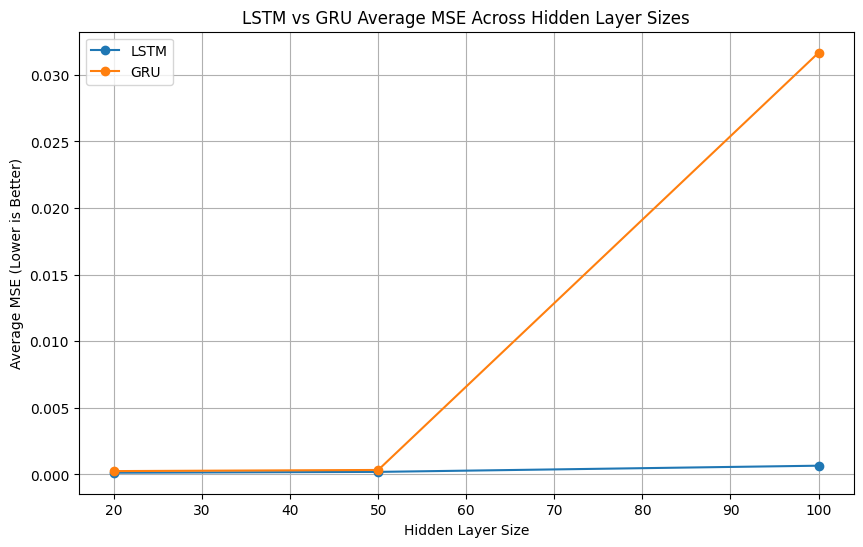

In [ ]:
# Plot the results for comparison
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_sizes, [results['LSTM'][size] for size in hidden_layer_sizes], label='LSTM', marker='o')
plt.plot(hidden_layer_sizes, [results['GRU'][size] for size in hidden_layer_sizes], label='GRU', marker='o')
plt.title('LSTM vs GRU Average MSE Across Hidden Layer Sizes')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Average MSE (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of the Results:**

**- Average MSE:** Compare the average MSE across different hidden layer sizes for both models to see which size performs best.

**- Model Choice:** If a particular model (e.g., LSTM) consistently achieves lower MSE, it may be better suited for your data.

**- Model Complexity:** Larger hidden layer sizes may improve performance but can lead to longer training times and risk of overfitting, so it’s essential to find the right balance.

### 7. Visualizing Training Loss and MSE Across Folds

To visualize **training loss** and **MSE across different folds** for more detailed analysis, we can extend the previous code to track the training loss for each epoch and each fold. After training, we will create plots to show:

1. **Training Loss per Epoch for each fold:** This helps to see how the model converges during training.

2. **MSE for Each Fold:** Visualize the MSE for each fold to understand the model's consistency across different subsets of data.
Here’s the updated code, including tracking of training loss and visualization.

**Note:**

- Each fold's losses are stored under its fold number for later visualization.

- *fold_mse* stores the MSE for each fold.

- We plot the MSE values for each fold using a bar plot to visualize consistency across folds.

**Visualize Training Loss:**

- **Training Loss per Fold:** Plot the training loss over epochs for each fold using matplotlib. This shows how the loss changes during training, helping to identify overfitting or underfitting patterns.
- Different line styles distinguish between LSTM and GRU.




Cross-validating LSTM Model...

LSTM Fold 1/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.086395
Epoch 10 Loss: 0.004472
Epoch 20 Loss: 0.001635
Epoch 30 Loss: 0.000938
Epoch 40 Loss: 0.000478
LSTM Fold 1 MSE: 0.000077

LSTM Fold 2/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.080221
Epoch 10 Loss: 0.001777
Epoch 20 Loss: 0.000336
Epoch 30 Loss: 0.000910
Epoch 40 Loss: 0.000323
LSTM Fold 2 MSE: 0.002884

LSTM Fold 3/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.078953
Epoch 10 Loss: 0.001141
Epoch 20 Loss: 0.000035
Epoch 30 Loss: 0.000005
Epoch 40 Loss: 0.000199
LSTM Fold 3 MSE: 0.000352
LSTM with Hidden Layer Size 50 Average MSE: 0.001104

Cross-validating GRU Model...

GRU Fold 1/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.062031
Epoch 10 Loss: 0.001263
Epoch 20 Loss: 0.000173
Epoch 30 Loss: 0.002453
Epoch 40 Loss: 0.000492
GRU Fold 1 MSE: 0.000105

GRU Fold 2/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.050846
Epoch 10 Loss: 0.004039
Epoch 20 Loss: 0.001031
Epoch 30 Loss: 0.001210
Epoch 40 Loss: 0.000900
GRU Fold 2 MSE: 0.002566

GRU Fold 3/3 with Hidden Layer Size: 50


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.073659
Epoch 10 Loss: 0.005423
Epoch 20 Loss: 0.000320
Epoch 30 Loss: 0.000150
Epoch 40 Loss: 0.000019
GRU Fold 3 MSE: 0.000051
GRU with Hidden Layer Size 50 Average MSE: 0.000907


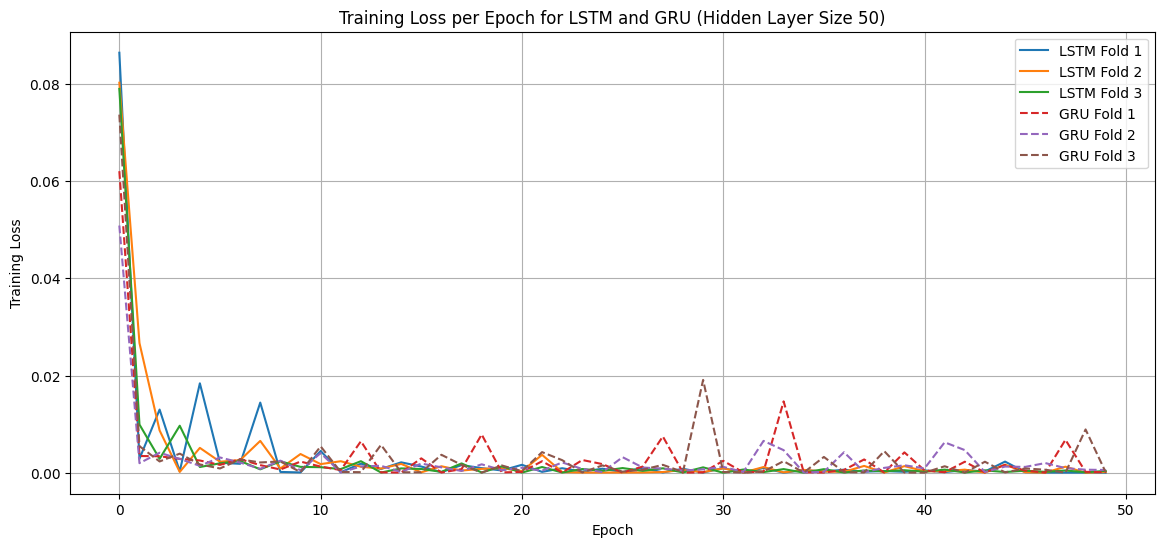

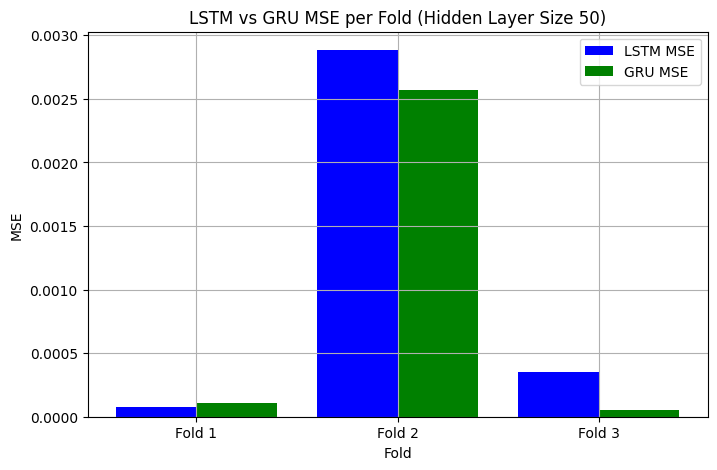

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate a simple time series (sine wave)
time_steps = np.linspace(0, 100, num=1000)
data = np.sin(time_steps)  # Sine wave as time series data

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Prepare input-output sequences for training
def create_inout_sequences(input_data, seq_length):
    inout_seq = []
    for i in range(len(input_data) - seq_length):
        train_seq = input_data[i:i + seq_length]
        train_label = input_data[i + seq_length]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 30
data_sequences = create_inout_sequences(data_normalized, seq_length)

# Define a base RNN model class that can be used for LSTM and GRU
class RNNBase(nn.Module):
    def __init__(self, rnn_type='LSTM', input_size=1, hidden_layer_size=50, output_size=1):
        super(RNNBase, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
        if self.rnn_type == 'LSTM':
            c_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size)
            rnn_out, _ = self.rnn(input_seq, (h_0, c_0))
        else:
            rnn_out, _ = self.rnn(input_seq, h_0)

        prediction = self.linear(rnn_out[:, -1])
        return prediction

# Function to train the model and return the loss history for k-fold cross-validation
def cross_validate_model(model_class, rnn_type, hidden_layer_size, data_sequences, k_folds=3, epochs=50, learning_rate=0.001):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_mse = []
    loss_history_per_fold = {} # We store the loss values for each epoch in each fold in a dictionary

    for fold, (train_idx, test_idx) in enumerate(kfold.split(data_sequences)):
        print(f'\n{rnn_type} Fold {fold + 1}/{k_folds} with Hidden Layer Size: {hidden_layer_size}')

        # Prepare train and test sequences for this fold
        train_sequences = [data_sequences[i] for i in train_idx]
        test_sequences = [data_sequences[i] for i in test_idx]

        # Convert sequences into PyTorch tensors
        train_sequences = [(torch.FloatTensor(seq).unsqueeze(1), torch.FloatTensor([label])) for seq, label in train_sequences]
        test_sequences = [(torch.FloatTensor(seq).unsqueeze(1), torch.FloatTensor([label])) for seq, label in test_sequences]

        # Instantiate the model
        model = model_class(rnn_type=rnn_type, hidden_layer_size=hidden_layer_size)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Track training loss for visualization
        training_losses = []

        # Train the model
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for seq, label in train_sequences:
                optimizer.zero_grad()
                y_pred = model(seq.unsqueeze(0))
                loss = loss_function(y_pred, label)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_epoch_loss = epoch_loss / len(train_sequences)
            training_losses.append(avg_epoch_loss)
            if epoch % 10 == 0:
                print(f'Epoch {epoch} Loss: {avg_epoch_loss:.6f}')

        # Store the training losses for this fold
        loss_history_per_fold[fold] = training_losses

        # Evaluate on the test set
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for seq, label in test_sequences:
                y_pred = model(seq.unsqueeze(0))
                predictions.append(y_pred.item())
                actuals.append(label.item())

        # Calculate MSE for this fold and store it
        fold_mse.append(mean_squared_error(actuals, predictions))
        print(f'{rnn_type} Fold {fold + 1} MSE: {fold_mse[-1]:.6f}')

    # Return the average MSE across all folds and the loss history
    avg_mse = np.mean(fold_mse)
    print(f'{rnn_type} with Hidden Layer Size {hidden_layer_size} Average MSE: {avg_mse:.6f}')
    return avg_mse, fold_mse, loss_history_per_fold

# Hyperparameter configurations to test
hidden_layer_size = 50  # Choose one hidden layer size for detailed analysis
k_folds = 3  # Number of folds for cross-validation
epochs = 50  # Training epochs for each fold

# Run cross-validation for LSTM and GRU
print("\nCross-validating LSTM Model...")
lstm_avg_mse, lstm_fold_mse, lstm_loss_history = cross_validate_model(RNNBase, 'LSTM', hidden_layer_size, data_sequences, k_folds=k_folds, epochs=epochs)

print("\nCross-validating GRU Model...")
gru_avg_mse, gru_fold_mse, gru_loss_history = cross_validate_model(RNNBase, 'GRU', hidden_layer_size, data_sequences, k_folds=k_folds, epochs=epochs)

# Plot the training loss for each fold for LSTM and GRU
plt.figure(figsize=(14, 6))

# Plot LSTM training loss for each fold
for fold in range(k_folds):
    plt.plot(lstm_loss_history[fold], label=f'LSTM Fold {fold + 1}', linestyle='-')
# Plot GRU training loss for each fold
for fold in range(k_folds):
    plt.plot(gru_loss_history[fold], label=f'GRU Fold {fold + 1}', linestyle='--')

plt.title(f'Training Loss per Epoch for LSTM and GRU (Hidden Layer Size {hidden_layer_size})')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the MSE for each fold for LSTM and GRU
plt.figure(figsize=(8, 5))
x_labels = [f'Fold {i+1}' for i in range(k_folds)]
x = np.arange(len(x_labels))

plt.bar(x - 0.2, lstm_fold_mse, width=0.4, label='LSTM MSE', color='blue')
plt.bar(x + 0.2, gru_fold_mse, width=0.4, label='GRU MSE', color='green')

plt.title(f'LSTM vs GRU MSE per Fold (Hidden Layer Size {hidden_layer_size})')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(x, x_labels)
plt.legend()
plt.grid(True)
plt.show()
